In [95]:
import sys
import os
from pathlib import Path

src_path = Path.home() / "QuditEM" / "src"

src_path = src_path.resolve()
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [96]:
from qudit_ops.operators import *
from qudit_ops.pcs import get_counts,plot_histogram,postselection
from qudit_ops.pcs import hellinger_fidelity
import math
import cirq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Applying PCS to a basic Modulo shift/Phase shift circuit in arbitrary dimension at different depolarizing error rates

In [98]:
mod_shift = 2
def ideal_modulo_circ(dim: int):
    qid = cirq.LineQid(0,dimension=dim)
    ideal_circuit = cirq.Circuit(ModAdd(mod_shift,dim).on(qid),cirq.measure(qid,key='Output'))
    # print(ideal_circuit)
    meas_sim = cirq.Simulator().run(ideal_circuit,repetitions=1024)
    ideal_res = get_counts(meas_sim,key='Output')
    # print(ideal_res)
    return ideal_res

def noisy_modulo_circ(dim: int,p: float):
    q = cirq.LineQid(0,dimension=dim)
    circ = cirq.Circuit(ModAdd(mod_shift,dim).on(q),QuditDepolarizingChannel(p,dim)(q))
    circ.append(cirq.measure(q,key='Output'))
    # print(circ)
    measured_noisy_circ = cirq.Simulator().run(circ,repetitions=1024)
    result_noisy_circ = get_counts(measured_noisy_circ,key='Output')
    # print(result_noisy_circ)
    return result_noisy_circ

def pcs_ideal_modulo_circ(dim: int):
    qids = cirq.LineQid.range(mod_shift,dimension=dim)
    # left_check = cirq.Moment()
    # right_check = cirq.Moment(cirq.Moment(CZGate(1,1,4).on(qudits1[0]),CZGate(2,2,4).on(qudits1[0]),CZGate(3,3,4).on(qudits1[0])))
    moment = (cirq.Moment(ModAdd(mod_shift,dim).on(qids[0])))
    
    circuit_pcs = cirq.Circuit()
    x_lcheck = lambda : [circuit_pcs.append(CModAdd(i,dim-i,dim).on(qids[1],qids[0])) for i in range(1,dim)]
    x_rcheck = lambda : [circuit_pcs.append(CModAdd(i,i,dim).on(qids[1],qids[0])) for i in range(1,dim)]
    circuit_pcs.append(Christensen(dim).on(qids[1]))
    x_lcheck()
    circuit_pcs.append(moment)
    x_rcheck()
    circuit_pcs.append(Christensen(dim).on(qids[1]))
    circuit_pcs.append(cirq.measure([*qids],key='a'))
    # print(circuit_pcs)

    meas_pcs_sim = cirq.Simulator().run(circuit_pcs,repetitions=1024)
    ideal_pcs_res = get_counts(meas_pcs_sim,key='a')
    # print(ideal_pcs_res)
    return ideal_pcs_res

def pcs_noisy_modulo_circ(dim: int, p: float):
    qids = cirq.LineQid.range(2, dimension=dim)
    moment = (cirq.Moment(ModAdd(2,dim).on(qids[0])))
    error_moment = cirq.Moment(QuditDepolarizingChannel(p,dim)(qids[0]))
    circuit_pcs = cirq.Circuit()
    x_lcheck = lambda : [circuit_pcs.append(CModAdd(i,dim-i,dim).on(qids[1],qids[0])) for i in range(1,dim)]
    x_rcheck = lambda : [circuit_pcs.append(CModAdd(i,i,dim).on(qids[1],qids[0])) for i in range(1,dim)]
    circuit_pcs.append(Christensen(dim).on(qids[1]))
    x_lcheck()
    circuit_pcs.append(moment)
    circuit_pcs.append(error_moment)
    x_rcheck()
    circuit_pcs.append(Christensen(dim).on(qids[1]))
    circuit_pcs.append(cirq.measure([*qids],key='a'))
    # print(circuit_pcs)

    meas_pcs_sim = cirq.Simulator().run(circuit_pcs, repetitions=1024)
    noisy_pcs_res = get_counts(meas_pcs_sim,key='a')

    ps_noisy_pcs_res = postselection(noisy_pcs_res, ancillas=1)
    # print(ps_noisy_pcs_res)
    return ps_noisy_pcs_res

In [99]:
# # ideal_modulo_circ = ideal_modulo_circ(4)
# # noisy_modulo_circ = noisy_modulo_circ(4, 0.1)
# # pcs_ideal_modulo_circ = pcs_ideal_modulo_circ(4)
# pcs_noisy_modulo_circ = pcs_noisy_modulo_circ(4, 0.1)
# # ideal_modulo_circ
# # noisy_modulo_circ
# # pcs_ideal_modulo_circ
# pcs_noisy_modulo_circ(4,0.1)

In [100]:
def sim_dep_error_rates(dim: int, p: float):
    ideal = ideal_modulo_circ(dim)
    noisy = noisy_modulo_circ(dim, p)
    pcs_ideal = pcs_ideal_modulo_circ(dim)
    pcs_noisy = pcs_noisy_modulo_circ(dim, p)
    
    unmitigated_fidelity = hellinger_fidelity(ideal,noisy)
    mitigated_fidelity = hellinger_fidelity(pcs_ideal,pcs_noisy)
    return p,unmitigated_fidelity, mitigated_fidelity

### Graph of fidelity performance of PCS circuit vs unmitigated circuit of arbitrary dimension

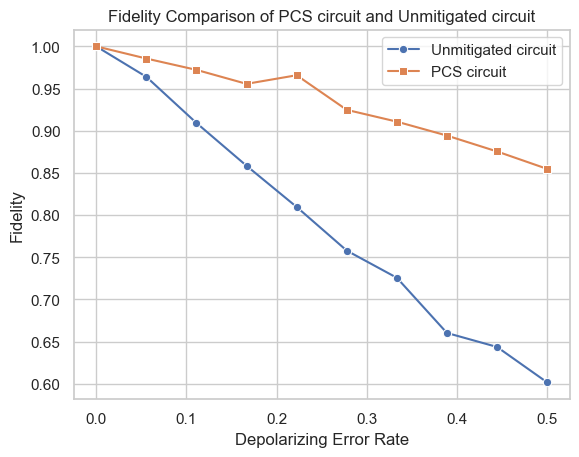

In [101]:
'''
Remove comment from this code and comment out the next cell to run this code
'''
def experiment_data():
    error_rates = []
    unmitigated_fidelities = []
    mitigated_fidelities = []
    for p in np.linspace(0,0.5,10):
        results = sim_dep_error_rates(4,p)
        error_rates.append(results[0])
        unmitigated_fidelities.append(results[1])
        mitigated_fidelities.append(results[2])
    return error_rates, unmitigated_fidelities, mitigated_fidelities

def plot_data(data):
    dep_errors, unmitigated, mitigated = data
    sns.set(style="whitegrid")
    sns.lineplot(x=dep_errors, y=unmitigated,
                label="Unmitigated circuit", marker="o")
    sns.lineplot(x=dep_errors, y=mitigated,
                label="PCS circuit", marker="s")

    plt.title("Fidelity Comparison of PCS circuit and Unmitigated circuit")
    plt.xlabel("Depolarizing Error Rate")
    plt.ylabel("Fidelity")
    plt.legend()
    plt.show()

plot_data(experiment_data())


## Graph of PCS fidelity performance across different dimensions

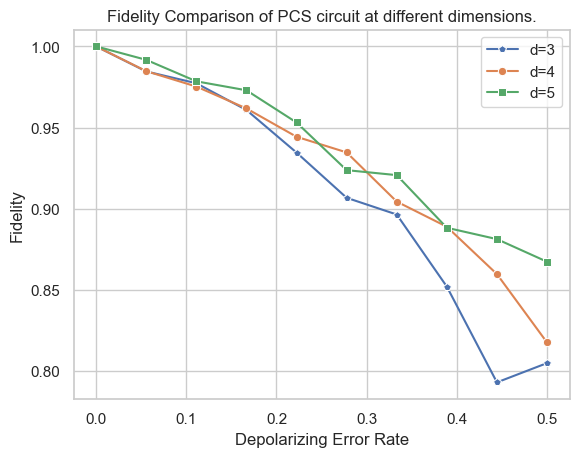

In [102]:

def dimension_data():
    dimension_fidelities = []
    for d in range(3,6):
        error_rates = []
        mitigated_fidelities = []
        for p in np.linspace(0,0.5,10):
            results = sim_dep_error_rates(d,p)
            error_rates.append(results[0])
            # unmitigated_fidelities.append(results[1])
            mitigated_fidelities.append(results[2])
        dimension_fidelities.append(mitigated_fidelities)
    return error_rates, dimension_fidelities

def plot_data(data):
    dep_errors, mitigated_data = data
    dim3,dim4,dim5 = mitigated_data
    sns.set(style="whitegrid")
    sns.lineplot(x=dep_errors,y=dim3, label="d=3",marker="p")
    sns.lineplot(x=dep_errors, y=dim4,
                label="d=4", marker="o")
    sns.lineplot(x=dep_errors, y=dim5,
                label="d=5", marker="s")

    plt.title("Fidelity Comparison of PCS circuit at different dimensions.")
    plt.xlabel("Depolarizing Error Rate")
    plt.ylabel("Fidelity")
    plt.legend()
    plt.show()


plot_data(dimension_data())